In [1]:
import os
from os import listdir
from os.path import isfile, join

import json
import nibabel as nib

import numpy as np

from tqdm.notebook import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations import pytorch

import segmentation_models_pytorch as smp

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 4
LEARNING_RATE = 5e-4
NUM_EPOCHS = 120

ALPHA = 0.3
BETA = 0.7

In [2]:
path = './data/data/'
filenames = [f for f in listdir(path + 'images') if isfile(join(path + 'images', f))]
filenames[:5]

['study_0255.nii',
 'study_0256.nii',
 'study_0257.nii',
 'study_0258.nii',
 'study_0259.nii']

In [3]:
class CovidDataset(Dataset):
    def __init__(self, filenames, transform, max_negatives):
        path = './data/data'
        path_images = os.path.join(path, 'images')
        path_labels = os.path.join(path, 'labels')
        
        self.transform = transform
        
        with open('training_data.json', 'r') as f:
            dict_training = json.load(f)
            
        self.images = []
        self.labels = []
        negatives = 0
        
        for entry in tqdm(dict_training):
            image = nib.load(os.path.join(path_images, entry['image'][:-3]))
            label = nib.load(os.path.join(path_labels, entry['label'][:-3]))
            image = torch.tensor(image.get_fdata(), dtype=torch.float32).transpose(1, 2).transpose(0, 1) 
            label = torch.tensor(label.get_fdata(), dtype=torch.float32).transpose(1, 2).transpose(0, 1)
            
            if entry['image'][:-3] in filenames:
                for i in range(len(image)):
                    if label[i].sum() != 0:
                        self.images.append(image[i].unsqueeze(0))
                        self.labels.append(label[i].unsqueeze(0))
                    else:
                        if negatives >= max_negatives:
                            continue
                        else:
                            negatives += 1
                            self.images.append(image[i].unsqueeze(0))
                            self.labels.append(label[i].unsqueeze(0))
                            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx].transpose(0, 1).transpose(1, 2).numpy()
        label = self.labels[idx].transpose(0, 1).transpose(1, 2).numpy()
        
        transformed = self.transform(image=image, label=label)
        image = transformed['image']
        label = transformed['label']
        
        return image, label

In [4]:
import random

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(),
        A.GaussianBlur(),
        A.Rotate(),
        A.GridDistortion(),
        A.Perspective(),
        A.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'label': 'image'}
)

val_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'label': 'image'}
)

In [5]:
train_dataset = CovidDataset(filenames[:33], train_transform, 50)
val_dataset = CovidDataset(filenames[33:], val_transform, 50)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        TP = (inputs * targets).sum()    
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)  
        
        return 1 - Tversky

In [7]:
model = smp.UnetPlusPlus(
    encoder_name='resnet18', 
    in_channels=1, 
    classes=1, 
    activation='sigmoid'
)

model = model.to(DEVICE)

criterion = TverskyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
history = []

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader)
    epoch_loss = []
    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        
        history.append(loss.item())
        epoch_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()
        
        del x
        del y
        torch.cuda.empty_cache()
        
    print('Epoch:', epoch)    
    print('Loss:', np.mean(epoch_loss))

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.8854409324384369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 1
Loss: 0.5216351024872434


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 2
Loss: 0.43703155338236715


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 3
Loss: 0.4289532113919216


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 4
Loss: 0.40556497331214164


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 5
Loss: 0.3834894019945533


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 6
Loss: 0.35691335348956355


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 7
Loss: 0.3543314849380898


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 8
Loss: 0.35181725763641625


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 9
Loss: 0.3628180269646434


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 10
Loss: 0.3523041104848406


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 11
Loss: 0.3493780108679712


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 12
Loss: 0.3663567737140487


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 13
Loss: 0.348760662880619


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 14
Loss: 0.33653021280744433


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 15
Loss: 0.3478957414627075


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 16
Loss: 0.33086120660326124


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 17
Loss: 0.3339071569189561


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 18
Loss: 0.3345400675208168


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 19
Loss: 0.34589056472862717


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 20
Loss: 0.3394407978100059


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 21
Loss: 0.3299613025336139


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 22
Loss: 0.31732168714557074


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 23
Loss: 0.32559026606315006


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 24
Loss: 0.3170205069854196


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 25
Loss: 0.3213453936365853


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 26
Loss: 0.321315430961879


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 27
Loss: 0.32098781271318416


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 28
Loss: 0.30814248534430444


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 29
Loss: 0.3148627555475826


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 30
Loss: 0.3077404367185272


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 31
Loss: 0.31906819660051733


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 32
Loss: 0.2959866750556811


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 33
Loss: 0.2920749071425041


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 34
Loss: 0.32448794092752237


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 35
Loss: 0.29487308253229194


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 36
Loss: 0.3026636918034174


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 37
Loss: 0.32138435925002645


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 38
Loss: 0.30302709499291614


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 39
Loss: 0.3036687094553382


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 40
Loss: 0.30093785566566267


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 41
Loss: 0.29303518755246055


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 42
Loss: 0.29941983033070524


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 43
Loss: 0.3133431752171137


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 44
Loss: 0.2983052408800716


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 45
Loss: 0.30909145300367236


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 46
Loss: 0.3062726834179026


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 47
Loss: 0.31714480376876564


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 48
Loss: 0.29363902374706435


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 49
Loss: 0.28134349647876433


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 50
Loss: 0.30192613337947205


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 51
Loss: 0.30672043720177844


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 52
Loss: 0.2863485195995432


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 53
Loss: 0.29103652935112473


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 54
Loss: 0.35572395757236314


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 55
Loss: 0.3170395889113435


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 56
Loss: 0.3071082002293747


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 57
Loss: 0.29471172009949137


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 58
Loss: 0.3213772562752783


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 59
Loss: 0.2865577851776528


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 60
Loss: 0.2902710052718103


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 61
Loss: 0.2859870100443342


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 62
Loss: 0.2937060198952666


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 63
Loss: 0.3065070409690384


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 64
Loss: 0.2870334154736679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 65
Loss: 0.3030008040698229


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 66
Loss: 0.28846076420978106


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 67
Loss: 0.28373861049128846


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 68
Loss: 0.27940149486592386


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 69
Loss: 0.28169132808668423


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 70
Loss: 0.2946918970715683


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 71
Loss: 0.26797985397608937


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 72
Loss: 0.27446237127337836


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 73
Loss: 0.28183398573799473


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 74
Loss: 0.27395753522889804


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 75
Loss: 0.2764323332668406


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 76
Loss: 0.2767558240257533


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 77
Loss: 0.28175166117406525


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 78
Loss: 0.28050095897860233


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 79
Loss: 0.26903125617356427


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 80
Loss: 0.2667382164339049


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 81
Loss: 0.27511149961336523


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 82
Loss: 0.27072996797814836


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 83
Loss: 0.28612299883260134


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 84
Loss: 0.28026084193086204


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 85
Loss: 0.27908946560547415


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 86
Loss: 0.3015533959971065


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 87
Loss: 0.2667245553658072


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 88
Loss: 0.26820873106475424


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 89
Loss: 0.2912695170503802


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 90
Loss: 0.2757219545609128


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 91
Loss: 0.26744404197794147


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 92
Loss: 0.2938635375647418


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 93
Loss: 0.26825689478258113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 94
Loss: 0.2683853649460109


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 95
Loss: 0.26859583633135903


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 96
Loss: 0.28241106841416486


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 97
Loss: 0.29144086879966535


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 98
Loss: 0.27628783736608725


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 99
Loss: 0.2552111982244306


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 100
Loss: 0.2740456097948868


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 101
Loss: 0.2582097069352074


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 102
Loss: 0.26735649172183684


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 103
Loss: 0.2635872353494695


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 104
Loss: 0.24771747599660823


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 105
Loss: 0.25554383275783166


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 106
Loss: 0.2606074904973528


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 107
Loss: 0.27075271110619065


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 108
Loss: 0.25760357833541603


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 109
Loss: 0.26483888119722887


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 110
Loss: 0.2669124429204823


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 111
Loss: 0.24802788379973015


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 112
Loss: 0.2595081292422472


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 113
Loss: 0.2733508111101336


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 114
Loss: 0.26586539977419693


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 115
Loss: 0.26037154999454465


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 116
Loss: 0.27677338893434644


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 117
Loss: 0.24971404117820536


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 118
Loss: 0.25607483313146945


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 119
Loss: 0.2570849999917292


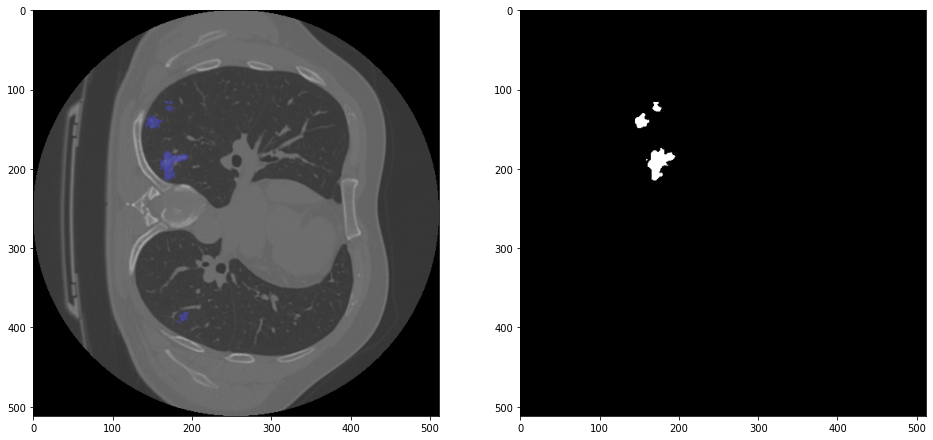

In [9]:
def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.3
    )

slices_num = (100, )
slices = []
for idx in slices_num:
    k = val_dataset[idx]
    slices.append(blend(
        k[0][0].numpy(),
        k[1][0].numpy()
    ))
    prediction = model.forward(k[0].view(1, 1, 512, 512).to(DEVICE)).cpu().detach().transpose(0, 1).transpose(1, 2).transpose(2, 3)[0]
    prediction[prediction >= 0.99] = 1
    prediction[prediction < 0.99] = 0
    slices.append(
        torch.cat([prediction, prediction, prediction], 2)
    )

figure = plt.figure(figsize=(16, 8))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [10]:
with open('testing_data.json', 'r') as f:
    dict_testing = json.load(f)

labels_predicted = []
images = []

for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path + 'images/', entry['image'][:-3]))
    images.append(image.get_fdata())
    image = torch.tensor(image.get_fdata(), dtype=torch.float32).transpose(1, 2).transpose(0, 1)
    
    layers = []
    for i in range(len(image)):
        x = image[i].to(DEVICE).view(-1, 1, 512, 512)
        prediction = model(x).cpu().detach()[0]
        prediction[prediction >= 0.99] = 1
        prediction[prediction < 0.99] = 0
        layers.append(prediction)
    
    labels_predicted.append(torch.concat(layers).transpose(0, 1).transpose(1, 2).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
labels_predicted[0].shape

(512, 512, 41)

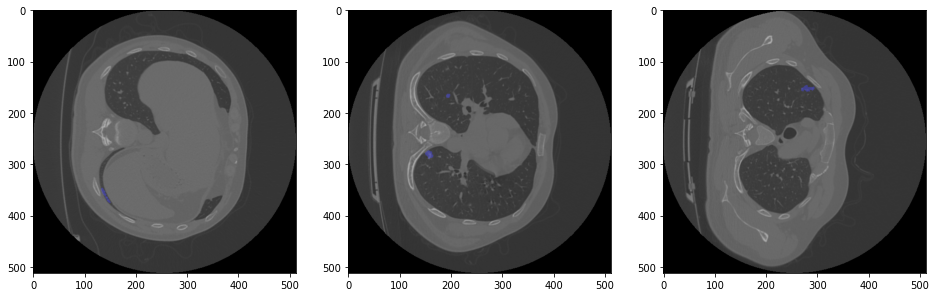

In [12]:
patient_num = 5
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images[patient_num][..., idx],
        labels_predicted[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(16, 6))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [13]:
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open('testing_data.json', 'r') as f:
            dict_testing = json.load(f)

with open(f'submission.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, labels_predicted)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])

0it [00:00, ?it/s]